In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

In [4]:
# !cp /content/drive/MyDrive/The\ School\ of\ AI/Session\ 6\ Assignment/model.py /content
# !cp /content/drive/MyDrive/The\ School\ of\ AI/Session\ 6\ Assignment/utils.py /content

In [5]:
# import model
# import utils
# from model import Net
# from utils import *

In [6]:
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

In [7]:
# train_transforms = A.Compose([
#         A.ShiftScaleRotate(shift_limit=0.09, scale_limit=0.09, rotate_limit=7, p=0.5),
#         # A.Affine(scale=0.9, translate_percent=(-0.1, 0.1), rotate=7, shear=[-7, 7], cval=0, fit_output=False, p=0.2),
#         # A.RandomResizedCrop(height=28, width=28, scale=(0.8, 1.0), p=0.5),
#         A.RandomBrightnessContrast(p=0.5),
#                 # A.GaussNoise(p=0.2),
#                 # A.Equalize(p=0.2),
#         A.Normalize(mean=(0.1307,), std=(0.3081,)),
#         ToTensorV2(),
#     ])

# test_transforms = A.Compose([
#         A.Normalize(mean=(0.1307,), std=(0.3081,)),
#         ToTensorV2(),
#     ])

In [8]:
# Train data transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(15),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test data transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                       ])

In [9]:
train_data = datasets.CIFAR10('../data', train=True, download=True, transform=train_transforms)
#test_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms) --> Commented the incorrect line. train = False and test_transform needs to be passed
test_data = datasets.CIFAR10('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:12<00:00, 13118258.73it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [10]:
type(train_data), len(train_data), len(train_data[0]), train_data.data.shape, test_data.data.shape

(torchvision.datasets.cifar.CIFAR10,
 50000,
 2,
 (50000, 32, 32, 3),
 (10000, 32, 32, 3))

In [11]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


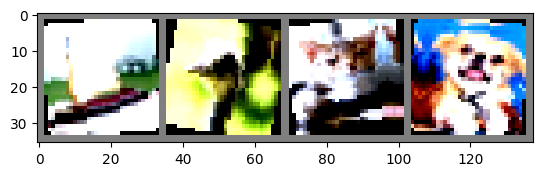

ship  bird  cat   dog  


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

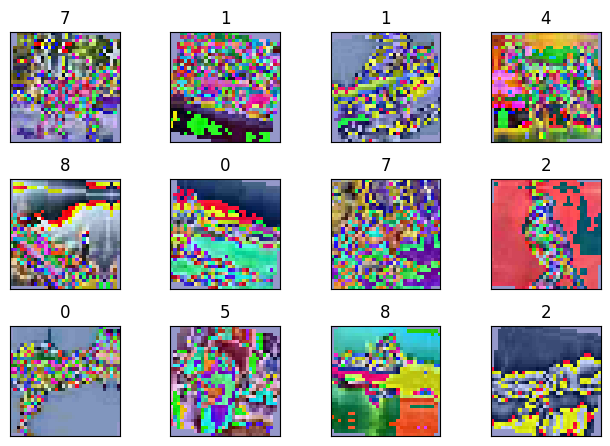

In [13]:
#batch_data, batch_label = next(iter(train_loader))
batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  #plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.imshow(transforms.ToPILImage()(batch_data[i]),interpolation='nearest')
  #plt.imshow(batch_data[i].squeeze(0))
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

In [14]:
GROUP_SIZE = 2

In [15]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # CONVOLUTION BLOCK 1 input 32/1/1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(GROUP_SIZE,32),
            nn.Dropout(dropout_value)
        ) # output_size = 32/3


        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(GROUP_SIZE,32),
            nn.Dropout(dropout_value)
        ) # output_size = 32/5

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 32/5
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 16/6/2

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(GROUP_SIZE,32),
            nn.Dropout(dropout_value)
        ) # output_size = 16/10/2

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(GROUP_SIZE,32),
            nn.Dropout(dropout_value)
        ) # output_size = 16/14/2

        # TRANSITION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 16/14/2
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 8/16/4

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(GROUP_SIZE,32),
            nn.Dropout(dropout_value)
        ) # output_size = 8/24/4
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(GROUP_SIZE,32),
            nn.Dropout(dropout_value)
        ) # output_size = 6/32/4

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(GROUP_SIZE,32),
            nn.Dropout(dropout_value)
        ) # output_size = 4/40/4

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = x + self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = x + self.convblock5(x)
        x = self.convblock6(x)
        x = self.pool1(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.gap(x)
        x = self.convblock10(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [16]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
         GroupNorm-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
         GroupNorm-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             512
        MaxPool2d-10           [-1, 16, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           4,608
             ReLU-12           [-1, 32, 16, 16]               0

In [17]:
from tqdm import tqdm

In [18]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Modifed structure below

In [20]:
def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

In [21]:
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [22]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.7771931886672974 Batch_id=97 Accuracy=28.66: 100%|██████████| 98/98 [00:42<00:00,  2.30it/s]



Test set: Average loss: 1.7339, Accuracy: 3764/10000 (37.64%)

EPOCH: 1


Loss=1.4667723178863525 Batch_id=97 Accuracy=40.41: 100%|██████████| 98/98 [00:32<00:00,  2.98it/s]



Test set: Average loss: 1.4417, Accuracy: 4735/10000 (47.35%)

EPOCH: 2


Loss=1.4091806411743164 Batch_id=97 Accuracy=47.22: 100%|██████████| 98/98 [00:33<00:00,  2.95it/s]



Test set: Average loss: 1.3405, Accuracy: 5143/10000 (51.43%)

EPOCH: 3


Loss=1.2869946956634521 Batch_id=97 Accuracy=51.55: 100%|██████████| 98/98 [00:34<00:00,  2.84it/s]



Test set: Average loss: 1.2794, Accuracy: 5479/10000 (54.79%)

EPOCH: 4


Loss=1.2746801376342773 Batch_id=97 Accuracy=54.31: 100%|██████████| 98/98 [00:33<00:00,  2.92it/s]



Test set: Average loss: 1.1329, Accuracy: 5942/10000 (59.42%)

EPOCH: 5


Loss=1.0475717782974243 Batch_id=97 Accuracy=57.53: 100%|██████████| 98/98 [00:33<00:00,  2.92it/s]



Test set: Average loss: 1.1089, Accuracy: 6057/10000 (60.57%)

EPOCH: 6


Loss=1.2431150674819946 Batch_id=97 Accuracy=59.29: 100%|██████████| 98/98 [00:33<00:00,  2.95it/s]



Test set: Average loss: 1.0270, Accuracy: 6351/10000 (63.51%)

EPOCH: 7


Loss=1.0893146991729736 Batch_id=97 Accuracy=60.47: 100%|██████████| 98/98 [00:33<00:00,  2.89it/s]



Test set: Average loss: 1.0568, Accuracy: 6221/10000 (62.21%)

EPOCH: 8


Loss=1.1056303977966309 Batch_id=97 Accuracy=61.92: 100%|██████████| 98/98 [00:33<00:00,  2.95it/s]



Test set: Average loss: 0.9599, Accuracy: 6575/10000 (65.75%)

EPOCH: 9


Loss=1.0394208431243896 Batch_id=97 Accuracy=63.23: 100%|██████████| 98/98 [00:35<00:00,  2.78it/s]



Test set: Average loss: 0.9578, Accuracy: 6574/10000 (65.74%)

EPOCH: 10


Loss=0.9228028059005737 Batch_id=97 Accuracy=63.64: 100%|██████████| 98/98 [00:33<00:00,  2.96it/s]



Test set: Average loss: 0.9409, Accuracy: 6637/10000 (66.37%)

EPOCH: 11


Loss=0.985289990901947 Batch_id=97 Accuracy=64.47: 100%|██████████| 98/98 [00:34<00:00,  2.87it/s]



Test set: Average loss: 0.9172, Accuracy: 6760/10000 (67.60%)

EPOCH: 12


Loss=0.9128953814506531 Batch_id=97 Accuracy=65.16: 100%|██████████| 98/98 [00:33<00:00,  2.95it/s]



Test set: Average loss: 0.8519, Accuracy: 7025/10000 (70.25%)

EPOCH: 13


Loss=0.9956275224685669 Batch_id=97 Accuracy=65.32: 100%|██████████| 98/98 [00:33<00:00,  2.92it/s]



Test set: Average loss: 0.8455, Accuracy: 7019/10000 (70.19%)

EPOCH: 14


Loss=1.0283212661743164 Batch_id=97 Accuracy=66.81: 100%|██████████| 98/98 [00:33<00:00,  2.95it/s]



Test set: Average loss: 0.8091, Accuracy: 7177/10000 (71.77%)

EPOCH: 15


Loss=0.9700928926467896 Batch_id=97 Accuracy=66.95: 100%|██████████| 98/98 [00:33<00:00,  2.92it/s]



Test set: Average loss: 0.8082, Accuracy: 7175/10000 (71.75%)

EPOCH: 16


Loss=1.0095140933990479 Batch_id=97 Accuracy=67.46: 100%|██████████| 98/98 [00:34<00:00,  2.87it/s]



Test set: Average loss: 0.8320, Accuracy: 7118/10000 (71.18%)

EPOCH: 17


Loss=0.8612114787101746 Batch_id=97 Accuracy=68.46: 100%|██████████| 98/98 [00:33<00:00,  2.91it/s]



Test set: Average loss: 0.7821, Accuracy: 7288/10000 (72.88%)

EPOCH: 18


Loss=0.9375338554382324 Batch_id=97 Accuracy=68.01: 100%|██████████| 98/98 [00:34<00:00,  2.83it/s]



Test set: Average loss: 0.7614, Accuracy: 7295/10000 (72.95%)

EPOCH: 19


Loss=0.8530100584030151 Batch_id=97 Accuracy=69.05: 100%|██████████| 98/98 [00:34<00:00,  2.87it/s]



Test set: Average loss: 0.7598, Accuracy: 7272/10000 (72.72%)



In [23]:
def get_incorrrect_predictions(model, loader, device):
    """Get all incorrect predictions

    Args:
        model (Net): Trained model
        loader (DataLoader): instance of data loader
        device (str): Which device to use cuda/cpu

    Returns:
        list: list of all incorrect predictions and their corresponding details
    """
    model.eval()
    incorrect = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target)
            pred = output.argmax(dim=1)
            for d, t, p, o in zip(data, target, pred, output):
                if p.eq(t.view_as(p)).item() == False:
                    incorrect.append(
                        [d.cpu(), t.cpu(), p.cpu(), o[p.item()].cpu()])

    return incorrect

In [24]:
def plot_incorrect_predictions(predictions, class_map, count=10):
    """Plot Incorrect predictions

    Args:
        predictions (list): List of all incorrect predictions
        class_map (dict): Lable mapping
        count (int, optional): Number of samples to print, multiple of 5. Defaults to 10.
    """
    print(f'Total Incorrect Predictions {len(predictions)}')

    if not count % 5 == 0:
        print("Count should be multiple of 10")
        return

    classes = list(class_map.values())

    fig = plt.figure(figsize=(10, 5))
    for i, (d, t, p, o) in enumerate(predictions):
        ax = fig.add_subplot(int(count/5), 5, i + 1, xticks=[], yticks=[])
        ax.set_title(f'{classes[t.item()]}/{classes[p.item()]}')
        plt.imshow(d.cpu().numpy().transpose(1, 2, 0))
        if i+1 == 5*(count/5):
            break

In [25]:
class_map = {
    'ZERO': 'plane',
    'ONE': 'car',
    'TWO': 'bird',
    'THREE': 'cat',
    'FOUR': 'deer',
    'FIVE': 'dog',
    'SIX': 'frog',
    'SEVEN': 'horse',
    'EIGHT': 'ship',
    'NINE': 'truck'
}

Total Incorrect Predictions 2728


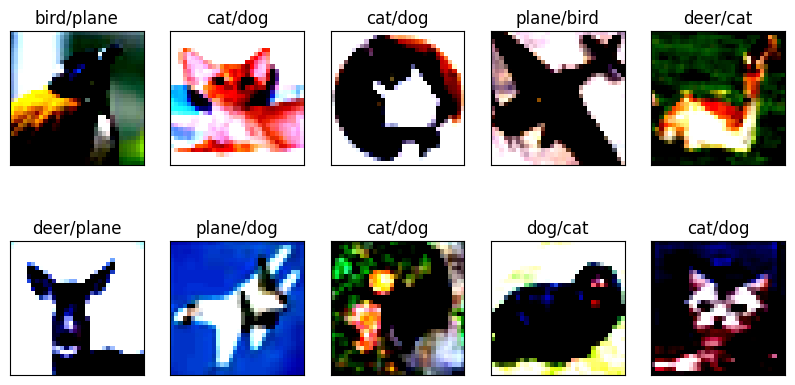

In [26]:
incorrect = get_incorrrect_predictions(model, test_loader, device)
plot_incorrect_predictions(incorrect, class_map)